In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers
from tensorflow.keras.applications import ResNet50V2, VGG16, DenseNet121
import os
import matplotlib.pyplot as plt
import matplotlib.image as img
from glob import glob

In [2]:
train = 'Train/'
val = 'Validation/'
test = 'Test/'

train_defective = os.listdir(train+'Defective')
train_non_defective = os.listdir(train+'Non defective')

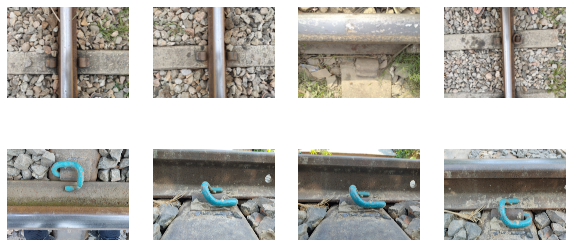

In [8]:
rows = 2
cols = 2

fig = plt.gcf() # 그릴려고 하는 figure 객체를 구하는 방법
fig.set_size_inches(cols * 5, rows * 5)

# 현재 가지고 있는 사진들에 path를 적용
next_defect = [os.path.join(train+'Defective', name) for name in train_defective[1:5]]
next_non_defect = [os.path.join(train+'Non defective', name) for name in train_non_defective[1:5]]

for i, img_path in enumerate(next_defect + next_non_defect):
    sub = plt.subplot(rows+2, cols+2, i+1)
    sub.axis('off')
    # img -> import matplotlib.image as img 
    image = img.imread(img_path)
    plt.imshow(image)
plt.show()
# 윗 줄은 아무 이상 없는 Rail
#아랫 줄은 고리가 끊어지거나 정비가 필요해 보이는 Rail

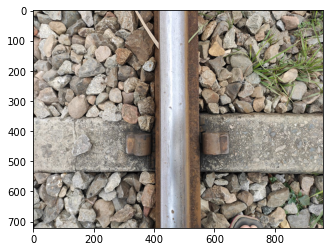

(721, 960, 3)

In [9]:
image = img.imread(next_defect[0])
plt.imshow(image)
plt.show()
image.shape

In [10]:
train_generator = ImageDataGenerator(rescale = 1./255, # scale 적용
                                     rotation_range = 40, # 회전 각도 범위
                                     width_shift_range=0.2, # 전체 가로 넓이 비율
                                     height_shift_range=0.2, # 전체 세로 넓이 비율
                                     shear_range=0.2, # 반시계 방향 층 밀어내기
                                     zoom_range=0.2, # 무작위 확대하기
                                     horizontal_flip=True, # 무작위로 가로로 뒤집기 
                                     vertical_flip=True) # 무작위로 세로로 뒤집기
                                     # 이렇게 다양하게 효과를 주는 이유는 
                                     # 사진 1장에 다양한 효과 (노이즈)를 줘서 하나의 이미지에서 다양한 결과를 추출하기 위함

train_gen = train_generator.flow_from_directory(train,
                                                target_size = (300, 300),
                                                batch_size = 16,
                                                color_mode = 'rgb',
                                                shuffle=True, # train에만 shuffle 적용  == test, val 적용하면 결과값이 계속 바뀌는 불상사 발생 
                                                seed=42,
                                                class_mode='categorical')
                                                # class_mode = binary 도 있는데 2가지의 클래스를 구분하기 위해 categorical로 적용
                                                # 정답과 정답이 아닌 것을 적용을 하려면 binary

Found 299 images belonging to 2 classes.


In [11]:
val_generator = ImageDataGenerator(rescale=1./255)

val_gen = val_generator.flow_from_directory(val,
                                            target_size=(300, 300),
                                            batch_size=16,
                                            color_mode='rgb',
                                            shuffle=False,
                                            class_mode='categorical')

Found 62 images belonging to 2 classes.


In [12]:
test_generator = ImageDataGenerator(rescale=1./255)

test_gen = test_generator.flow_from_directory(test,
                                              target_size=(300, 300),
                                              batch_size=16,
                                              color_mode='rgb',
                                              shuffle=False,
                                              class_mode='categorical')

Found 22 images belonging to 2 classes.


In [13]:
resnet = ResNet50V2(input_shape = (300, 300, 3), weights='imagenet', include_top=False)
resnet.trainable = False # 가져온 모델이 가중치 업데이트를 하지 못하게 함

x=resnet.output
x=layers.GlobalAveragePooling2D()(x)
x=layers.Dense(128,activation='relu')(x)  
preds=layers.Dense(2,activation='softmax')(x) 

resnet_model=models.Model(inputs=resnet.input,outputs=preds)
resnet_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 306, 306, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 150, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 152, 152, 64) 0           conv1_conv[0][0]                 
______________________________________________________________________________________________

In [14]:
vgg = VGG16(input_shape = (300, 300, 3), weights='imagenet', include_top=False)
vgg.trainable = False # 가져온 모델이 가중치 업데이트를 하지 못하게 함

x=vgg.output
x=layers.GlobalAveragePooling2D()(x)
x=layers.Dense(128,activation='relu')(x)  
preds=layers.Dense(2,activation='softmax')(x) 

vgg_model=models.Model(inputs=vgg.input,outputs=preds)
vgg_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)       0   

In [15]:
dense = DenseNet121(input_shape = (300, 300, 3), weights='imagenet', include_top=False)
dense.trainable = False # 가져온 모델이 가중치 업데이트를 하지 못하게 함

x=dense.output
x=layers.GlobalAveragePooling2D()(x)
x=layers.Dense(128,activation='relu')(x)  
preds=layers.Dense(2,activation='softmax')(x) 

dense_model=models.Model(inputs=dense.input,outputs=preds)
dense_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 306, 306, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 150, 150, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 150, 150, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [16]:
step_size_train = train_gen.n//train_gen.batch_size # train_gen.n -> .n (이미지 개수) // 16 (batch_size)
step_size_val = val_gen.n // val_gen.batch_size# val_gen.n -> .n (이미지 개수) // 16 (batch_size)
step_size_test = test_gen.n // test_gen.batch_size# test_gen.n -> .n (이미지 개수) // 16 (batch_size)
epochs=20

In [19]:
resnet_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

history = resnet_model.fit(train_gen,
                    steps_per_epoch=step_size_train, # 1번의 epoch 를 18번 반복
                    epochs=epochs,
                    validation_data=val_gen,
                    validation_steps=step_size_val) # 1번의 epoch를 3번 반복

Epoch 1/20
18/18 [==============================] - 49s 3s/step - loss: 0.5986 - accuracy: 0.6749 - val_loss: 0.3875 - val_accuracy: 0.8125
Epoch 2/20
18/18 [==============================] - 44s 2s/step - loss: 0.4099 - accuracy: 0.8163 - val_loss: 0.5556 - val_accuracy: 0.6875
Epoch 3/20
18/18 [==============================] - 43s 2s/step - loss: 0.4474 - accuracy: 0.7915 - val_loss: 0.3155 - val_accuracy: 0.9167
Epoch 4/20
18/18 [==============================] - 43s 2s/step - loss: 0.3792 - accuracy: 0.8127 - val_loss: 0.2910 - val_accuracy: 0.9167
Epoch 5/20
18/18 [==============================] - 43s 2s/step - loss: 0.3280 - accuracy: 0.8576 - val_loss: 0.3694 - val_accuracy: 0.8542
Epoch 6/20
18/18 [==============================] - 43s 2s/step - loss: 0.3410 - accuracy: 0.8445 - val_loss: 0.3660 - val_accuracy: 0.8542
Epoch 7/20
18/18 [==============================] - 43s 2s/step - loss: 0.3141 - accuracy: 0.8481 - val_loss: 0.2755 - val_accuracy: 0.8958
Epoch 8/20
18/18 [==

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


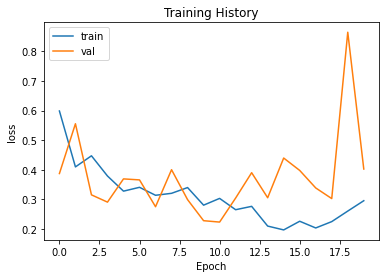

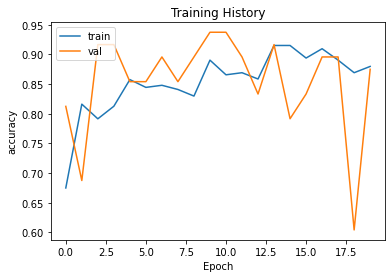

In [21]:
print(history.history.keys())
# model이 돌아갈때 history 변수에 담아줘서 가능함

def show_train_history(hisData,train,val): 
    plt.plot(hisData.history[train])
    plt.plot(hisData.history[val])
    plt.title('Training History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

show_train_history(history, 'loss', 'val_loss')

show_train_history(history, 'accuracy', 'val_accuracy')

In [22]:
vgg_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

history_vgg = vgg_model.fit(train_gen,
                    steps_per_epoch=step_size_train,
                    epochs=epochs,
                    validation_data=val_gen,
                    validation_steps=step_size_val)

Epoch 1/20
18/18 [==============================] - 48s 2s/step - loss: 0.7070 - accuracy: 0.5265 - val_loss: 0.6301 - val_accuracy: 0.6250
Epoch 2/20
18/18 [==============================] - 43s 2s/step - loss: 0.6210 - accuracy: 0.6396 - val_loss: 0.4676 - val_accuracy: 0.8333
Epoch 3/20
18/18 [==============================] - 44s 2s/step - loss: 0.5931 - accuracy: 0.6806 - val_loss: 0.4416 - val_accuracy: 0.8125
Epoch 4/20
18/18 [==============================] - 43s 2s/step - loss: 0.5975 - accuracy: 0.6608 - val_loss: 0.4324 - val_accuracy: 0.8125
Epoch 5/20
18/18 [==============================] - 44s 2s/step - loss: 0.5761 - accuracy: 0.6608 - val_loss: 0.3851 - val_accuracy: 0.8125
Epoch 6/20
18/18 [==============================] - 43s 2s/step - loss: 0.5473 - accuracy: 0.7208 - val_loss: 0.3964 - val_accuracy: 0.8125
Epoch 7/20
18/18 [==============================] - 44s 2s/step - loss: 0.5160 - accuracy: 0.7491 - val_loss: 0.3692 - val_accuracy: 0.8333
Epoch 8/20
18/18 [==

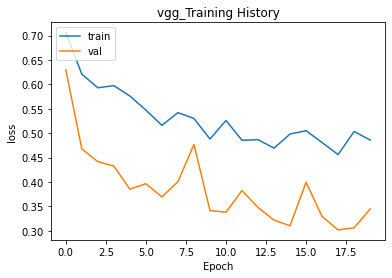

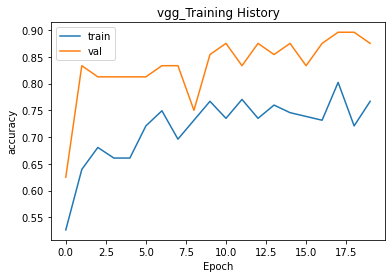

In [23]:
def show_train_history(hisData,train,val): 
    plt.plot(hisData.history[train])
    plt.plot(hisData.history[val])
    plt.title('vgg_Training History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

show_train_history(history_vgg, 'loss', 'val_loss')

show_train_history(history_vgg, 'accuracy', 'val_accuracy')

In [24]:
dense_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

history_dense = dense_model.fit(train_gen,
                    steps_per_epoch=step_size_train,
                    epochs=epochs,
                    validation_data=val_gen,
                    validation_steps=step_size_val)

Epoch 1/20
18/18 [==============================] - 56s 3s/step - loss: 0.6677 - accuracy: 0.6042 - val_loss: 0.5760 - val_accuracy: 0.7708
Epoch 2/20
18/18 [==============================] - 44s 2s/step - loss: 0.5300 - accuracy: 0.7244 - val_loss: 0.3621 - val_accuracy: 0.8750
Epoch 3/20
18/18 [==============================] - 44s 2s/step - loss: 0.4978 - accuracy: 0.7562 - val_loss: 0.3855 - val_accuracy: 0.8750
Epoch 4/20
18/18 [==============================] - 44s 2s/step - loss: 0.4361 - accuracy: 0.7915 - val_loss: 0.4255 - val_accuracy: 0.7917
Epoch 5/20
18/18 [==============================] - 45s 2s/step - loss: 0.4343 - accuracy: 0.8127 - val_loss: 0.3220 - val_accuracy: 0.8958
Epoch 6/20
18/18 [==============================] - 44s 2s/step - loss: 0.3895 - accuracy: 0.8233 - val_loss: 0.2677 - val_accuracy: 0.9167
Epoch 7/20
18/18 [==============================] - 44s 2s/step - loss: 0.4093 - accuracy: 0.7915 - val_loss: 0.3886 - val_accuracy: 0.8125
Epoch 8/20
18/18 [==

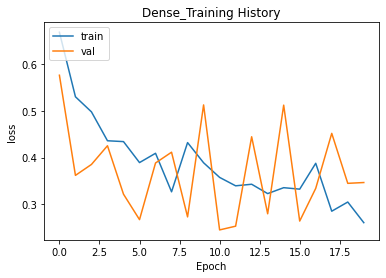

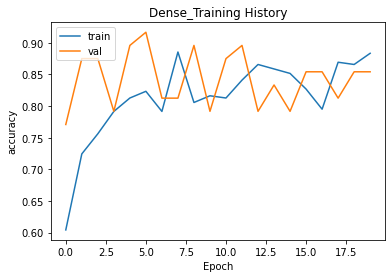

In [25]:
dense_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

history_dense = dense_model.fit(train_gen,
                    steps_per_epoch=step_size_train,
                    epochs=epochs,
                    validation_data=val_gen,
                    validation_steps=step_size_val)

def show_train_history(hisData,train,val): 
    plt.plot(hisData.history[train])
    plt.plot(hisData.history[val])
    plt.title('Dense_Training History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

show_train_history(history_dense, 'loss', 'val_loss')

show_train_history(history_dense, 'accuracy', 'val_accuracy')

In [28]:
resnet_model_score = resnet_model.evaluate(test_gen, steps=step_size_test)
vgg_model_score = vgg_model.evaluate(test_gen, steps=step_size_test)
dense_model_score = dense_model.evaluate(test_gen, steps=step_size_test)

1/1 [==============================] - 2s 2s/step - loss: 0.5688 - accuracy: 0.6875


In [29]:
print(f'Resnet_score : {resnet_model_score}, Vgg_score : {vgg_model_score}, Dense_score : {dense_model_score}')

Resnet_score : [0.38427063822746277, 0.875], Vgg_score : [0.5397213697433472, 0.75], Dense_score : [0.5688139796257019, 0.6875]
